In [2]:
import numpy as np
import scipy as sp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt


def cubic(s, a, b, c, k0):
    """Defines a cubic polynomial x(s) = k0 + a*s + b*s^2 + c*s^3"""
    return k0 + a * s + b * s**2 + c * s**3


def cubic_integral(s, a, b, c, k0):
    return k0 * s + (a / 2) * (s**2) + (b / 3) * (s**3) + (c / 4) * (s**4)


def posture(s, a, b, c, k0, num_pts: int = 1000):
    ss = jnp.linspace(0, s, num_pts)
    x = jsp.integrate.trapezoid(jnp.cos(cubic_integral(ss, a, b, c, k0)), ss)
    y = jsp.integrate.trapezoid(jnp.sin(cubic_integral(ss, a, b, c, k0)), ss)
    yaw = cubic_integral(s, a, b, c, k0)
    k = cubic(s, a, b, c, k0)
    return jnp.array([x, y, yaw, k])


def initial_guess(start, goal):
    # Set an initial guess for [s, a, b, c]. 
    # Heuristics from Section 3.1 of https://www.ri.cmu.edu/publications/trajectory-generation-for-car-like-robots-using-cubic-curvature-polynomials/
    k0 = start[3]
    
    xyf = goal[0:2]
    yawf = goal[2]
    kf = goal[3]

    d = np.linalg.norm(xyf)
    yaw = np.abs(yawf)
    s0 = d * ((0.2 * (yaw**2)) + 1.0) + 0.4 * yaw
    a0 = ((6 * yaw) / (s0**2)) + 2 * ((2 * kf - k0) / s0)
    b0 = ((3 / (s0**2)) * (k0 + kf)) + ((6 * yawf) / (s0**3))
    c0 = 0.0

    return jnp.array([s0, a0, b0, c0])


def steer(start, goal, tol: float = 0.01, max_iters: int = 100, reg: float = 0.001):
    scale = jnp.array([1.0, 1.0, 4.0, 1.0])

    def residual(params):
        k0 = start[3]
        s, a, b, c = params
        return scale * (posture(s, a, b, c, k0) - goal)

    # NOTE: with this formulation it is trivial to add more terms into the optimization e.g for penalizing path length, sharpness, etc.
    # def objective(params):
    #     r = residual(params)
    #     return 0.5 * jnp.dot(r, r)
    
    # g = jax.grad(objective)
    # h = jax.hessian(objective)

    # Create the derivative functions
    j = jax.jacobian(residual)

    # Get an initial guess
    params = initial_guess(start, goal)

    # Levenberg-Marquadt w/ gradient-norm regularization
    # https://arxiv.org/abs/2112.02089
    # TODO use adaptive version AdaN+ or https://arxiv.org/abs/2208.05888
    for i in range(max_iters):
        rval = residual(params)
        jval = j(params)
        gval = jval.T @ rval
        hval = jval.T @ jval
        
        gnorm = jnp.linalg.norm(gval)
        r = reg * (gnorm**0.5)
        delta = jnp.linalg.solve(hval + r * jnp.eye(hval.shape[0]), gval)

        print(f"Iteration {i}: params = {params}, ||grad|| = {gnorm}, residual = {rval}")

        # Perform update
        params -= delta

        # Check for convergence
        if jnp.all(jnp.abs(rval) < tol * scale):
            break
    return params

Iteration 0: params = [1.4597764  2.759435   0.87840843 0.        ], ||grad|| = 735.006103515625, residual = [-0.84678084  0.17880656 24.384413    6.2000003 ]
Iteration 1: params = [ 0.71306974  2.593767    0.6606189  -0.46610764], ||grad|| = 113.85649871826172, residual = [-0.45533115  0.16151528  8.830425    2.3164423 ]
Iteration 2: params = [ 0.03250456  2.1412508   0.49578995 -0.5250096 ], ||grad|| = 13.85350227355957, residual = [-0.96750146 -0.19945948  3.2761579   0.37010628]
Iteration 3: params = [-0.5452413   2.8480792   0.5192596  -0.52423865], ||grad|| = 6.847089767456055, residual = [-1.5390949  -0.12355557  2.4954703  -1.013545  ]
Iteration 4: params = [ 0.4784295   0.96283937 -1.8651861   1.7009296 ], ||grad|| = 25.759140014648438, residual = [-0.54376626 -0.0769977   5.3128633   0.5199881 ]
Iteration 5: params = [-0.46274132  0.0687502  -1.8342916   1.8262913 ], ||grad|| = 0.9869211912155151, residual = [-1.4498096  -0.10429697  1.6461467  -0.30555046]
Iteration 6: param

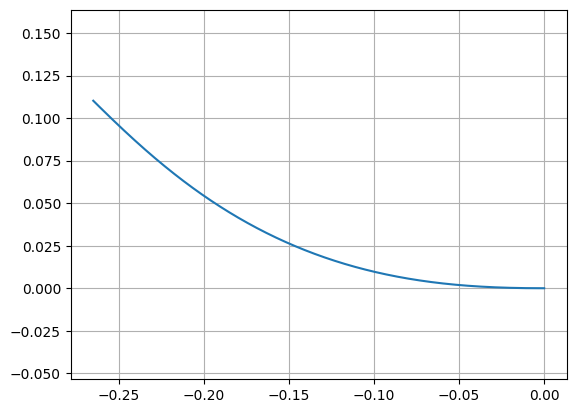

In [3]:
# NOTE: This routine is NOT scale invariant. Making the goal farther away e.g. [10, 1, 0, 0] can cause weird issues.
# x, y, yaw, v
start = np.array([0.0, 0.0, 0.0, 1.0])
goal = np.array([1.0, 0.2, -45 * 2*np.pi/360, 0.7])
k0 = start[3]
params = steer(start, goal, max_iters=100, reg=0.01)

sf, a, b, c = params
ss = np.linspace(0, sf, 1000)
ps = np.vstack([posture(s, a, b, c, k0) for s in ss])

plt.plot(ps[:, 0], ps[:, 1])
plt.axis("equal")
plt.grid()
plt.show()